In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F


In [5]:


# Load data
train_data = torch.load('train.pt')
val_data = torch.load('val.pt')
test_data = torch.load('test.pt')

# Prepare dataset
def prepare_dataset(data):
    eeg_list = []
    stim_list = []
    for eeg, stim in data:
        eeg_list.append(eeg.float())           # (320, 64)
        stim_list.append(stim.float())         # (320,)
    eeg_tensor = torch.stack(eeg_list)         # (N, 320, 64)
    stim_tensor = torch.stack(stim_list)       # (N, 320)
    return eeg_tensor, stim_tensor

X_train, y_train = prepare_dataset(train_data)
X_val, y_val = prepare_dataset(val_data)
X_test, y_test = prepare_dataset(test_data)



Epoch 1/5: 100%|██████████████████████████████████████████████████| 2856/2856 [01:18<00:00, 36.29it/s, train_loss=0.936]


Epoch 1/5:
  Train Loss: 0.9104
  Val Loss: 0.9021
  Val MSE: 0.3229
  Val Pearson: 0.0979
  Val Cosine Similarity: 0.7421


Epoch 2/5: 100%|██████████████████████████████████████████████████| 2856/2856 [01:19<00:00, 36.13it/s, train_loss=0.863]


Epoch 2/5:
  Train Loss: 0.8909
  Val Loss: 0.8906
  Val MSE: 0.2698
  Val Pearson: 0.1094
  Val Cosine Similarity: 0.7915


Epoch 3/5: 100%|██████████████████████████████████████████████████| 2856/2856 [01:18<00:00, 36.17it/s, train_loss=0.866]


Epoch 3/5:
  Train Loss: 0.8817
  Val Loss: 0.8895
  Val MSE: 0.3499
  Val Pearson: 0.1105
  Val Cosine Similarity: 0.7701


Epoch 4/5: 100%|██████████████████████████████████████████████████| 2856/2856 [01:18<00:00, 36.19it/s, train_loss=0.804]


Epoch 4/5:
  Train Loss: 0.8749
  Val Loss: 0.8884
  Val MSE: 0.3338
  Val Pearson: 0.1116
  Val Cosine Similarity: 0.7792


Epoch 5/5: 100%|██████████████████████████████████████████████████| 2856/2856 [01:19<00:00, 36.14it/s, train_loss=0.844]


Epoch 5/5:
  Train Loss: 0.8689
  Val Loss: 0.8871
  Val MSE: 0.3746
  Val Pearson: 0.1129
  Val Cosine Similarity: 0.7848


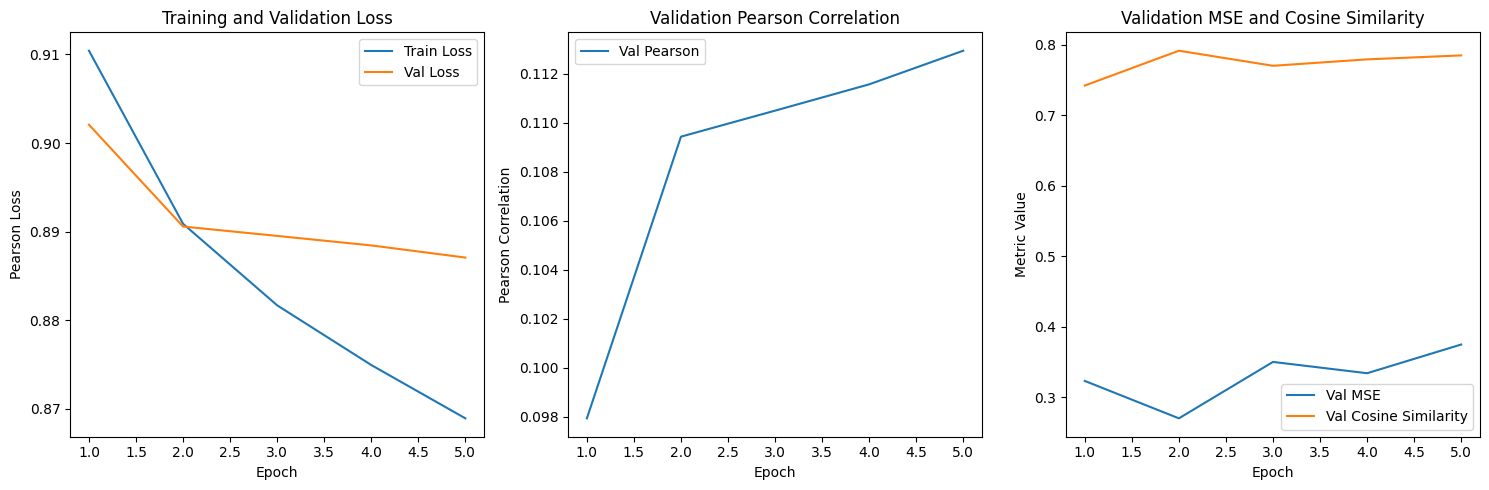

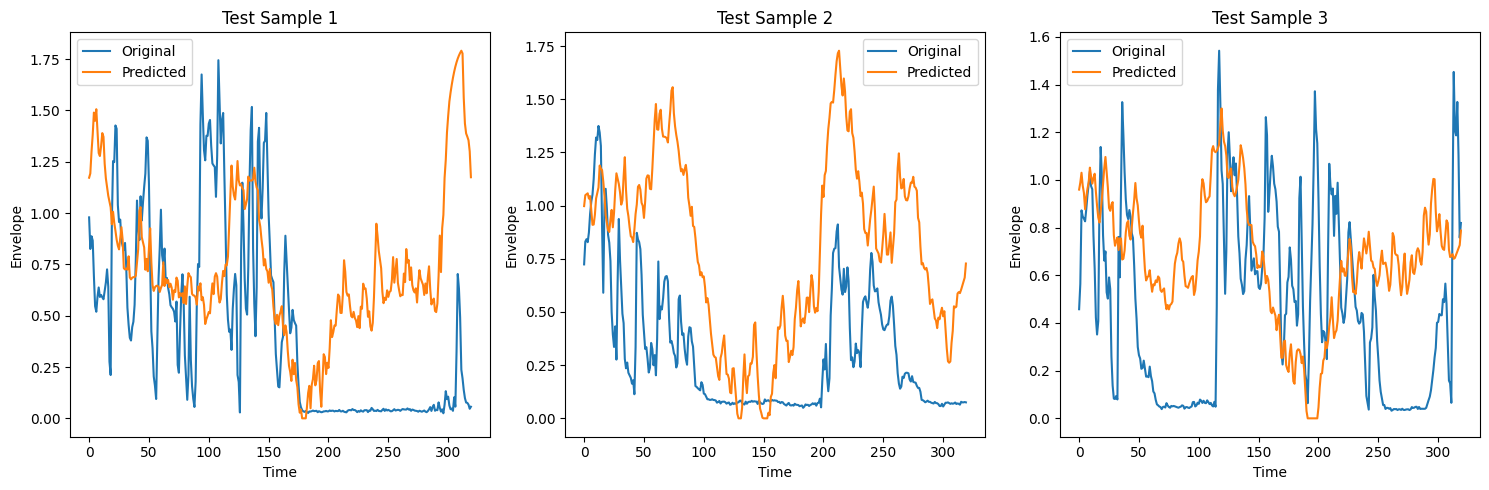

In [7]:

# Define hyperparameters in one place
hyperparameters = {
    'input_size': 64,           # Number of EEG channels
    'lstm_hidden_size': 128,    # Number of units in LSTM hidden layers
    'cnn_channels': 64,         # Number of filters in CNN layers
    'kernel_size': 3,           # CNN kernel size
    'num_blocks': 4,            # Number of LSTM+CNN blocks
    'lstm_layers': 2,           # Number of LSTM layers per block
    'cnn_layers': 2,            # Number of CNN layers per block
    'dropout': 0.3,             # Dropout rate
    'learning_rate': 0.001,     # Learning rate
    'batch_size': 32,           # Batch size
    'num_epochs': 5,            # Number of epochs (low for initial testing)
    'data_fraction': 1       # Use 1% of the data
}

# Define the Pearson Correlation loss function
class PearsonLoss(nn.Module):
    def __init__(self):
        super(PearsonLoss, self).__init__()

    def forward(self, pred, target):
        pred = pred - torch.mean(pred, dim=1, keepdim=True)
        target = target - torch.mean(target, dim=1, keepdim=True)
        pred_norm = torch.sqrt(torch.sum(pred ** 2, dim=1, keepdim=True))
        target_norm = torch.sqrt(torch.sum(target ** 2, dim=1, keepdim=True))
        correlation = torch.sum(pred * target, dim=1, keepdim=True) / (pred_norm * target_norm + 1e-8)
        return 1 - torch.mean(correlation)

# Define the model
class EEG2EnvModel(nn.Module):
    def __init__(self, input_size, lstm_hidden_size, cnn_channels, kernel_size, num_blocks, lstm_layers, cnn_layers, dropout):
        super(EEG2EnvModel, self).__init__()
        self.input_size = input_size
        self.lstm_hidden_size = lstm_hidden_size
        self.cnn_channels = cnn_channels
        self.num_blocks = num_blocks

        # Define blocks
        self.blocks = nn.ModuleList()
        current_channels = input_size

        for _ in range(num_blocks):
            # LSTM layers
            lstm = nn.LSTM(
                input_size=current_channels,
                hidden_size=lstm_hidden_size,
                num_layers=lstm_layers,
                batch_first=True,
                dropout=dropout if lstm_layers > 1 else 0
            )
            # CNN layers
            cnn_layers_list = []
            for _ in range(cnn_layers):
                cnn_layers_list.append(
                    nn.Conv1d(
                        in_channels=lstm_hidden_size if _ == 0 else cnn_channels,
                        out_channels=cnn_channels,
                        kernel_size=kernel_size,
                        padding=kernel_size // 2
                    )
                )
                cnn_layers_list.append(nn.ReLU())
                cnn_layers_list.append(nn.Dropout(dropout))
            cnn = nn.Sequential(*cnn_layers_list)
            self.blocks.append(nn.ModuleList([lstm, cnn]))
            current_channels = cnn_channels

        # Final linear layer to map to output (1D envelope)
        self.fc = nn.Linear(cnn_channels, 1)

    def forward(self, x):
        # x shape: (batch, seq_len, input_size)
        batch_size, seq_len, _ = x.size()

        for lstm, cnn in self.blocks:
            # LSTM forward
            x, _ = lstm(x)  # (batch, seq_len, lstm_hidden_size)
            # Transpose for CNN: (batch, lstm_hidden_size, seq_len)
            x = x.permute(0, 2, 1)
            # CNN forward
            x = cnn(x)  # (batch, cnn_channels, seq_len)
            # Transpose back: (batch, seq_len, cnn_channels)
            x = x.permute(0, 2, 1)

        # Final linear layer with ReLU activation
        x = self.fc(x)  # (batch, seq_len, 1)
        x = F.relu(x)   # Apply ReLU activation
        return x.squeeze(-1)  # (batch, seq_len)

# Function to compute metrics
def compute_metrics(pred, target):
    pred = pred.detach().cpu().numpy()
    target = target.detach().cpu().numpy()
    mse = np.mean([mean_squared_error(t, p) for t, p in zip(target, pred)])
    pearson = np.mean([pearsonr(t, p)[0] for t, p in zip(target, pred)])
    cos_sim = np.mean([np.dot(t, p) / (np.linalg.norm(t) * np.linalg.norm(p) + 1e-8) for t, p in zip(target, pred)])
    return mse, pearson, cos_sim

# Subsample data
def subsample_data(X, y, fraction):
    n_samples = X.shape[0]
    indices = np.random.choice(n_samples, size=int(n_samples * fraction), replace=False)
    return X[indices], y[indices]

# Training function
def train_model(model, X_train, y_train, X_val, y_val, hyperparameters):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = PearsonLoss()
    optimizer = optim.Adam(model.parameters(), lr=hyperparameters['learning_rate'])
    batch_size = hyperparameters['batch_size']
    num_epochs = hyperparameters['num_epochs']

    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_train, y_train),
        batch_size=batch_size,
        shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_val, y_val),
        batch_size=batch_size
    )

    train_losses = []
    val_losses = []
    val_metrics = {'mse': [], 'pearson': [], 'cos_sim': []}

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for batch_X, batch_y in progress_bar:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            output = model(batch_X)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * batch_X.size(0)
            progress_bar.set_postfix({'train_loss': loss.item()})

        epoch_train_loss /= len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation
        model.eval()
        epoch_val_loss = 0
        val_preds, val_targets = [], []
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                output = model(batch_X)
                loss = criterion(output, batch_y)
                epoch_val_loss += loss.item() * batch_X.size(0)
                val_preds.append(output)
                val_targets.append(batch_y)

        epoch_val_loss /= len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        # Compute metrics
        val_preds = torch.cat(val_preds, dim=0)
        val_targets = torch.cat(val_targets, dim=0)
        mse, pearson, cos_sim = compute_metrics(val_preds, val_targets)
        val_metrics['mse'].append(mse)
        val_metrics['pearson'].append(pearson)
        val_metrics['cos_sim'].append(cos_sim)

        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"  Train Loss: {epoch_train_loss:.4f}")
        print(f"  Val Loss: {epoch_val_loss:.4f}")
        print(f"  Val MSE: {mse:.4f}")
        print(f"  Val Pearson: {pearson:.4f}")
        print(f"  Val Cosine Similarity: {cos_sim:.4f}")

    return train_losses, val_losses, val_metrics

# Plotting function
def plot_metrics(train_losses, val_losses, val_metrics):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(15, 5))
    
    # Plot Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Pearson Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot Pearson Correlation
    plt.subplot(1, 3, 2)
    plt.plot(epochs, val_metrics['pearson'], label='Val Pearson')
    plt.xlabel('Epoch')
    plt.ylabel('Pearson Correlation')
    plt.title('Validation Pearson Correlation')
    plt.legend()

    # Plot MSE and Cosine Similarity
    plt.subplot(1, 3, 3)
    plt.plot(epochs, val_metrics['mse'], label='Val MSE')
    plt.plot(epochs, val_metrics['cos_sim'], label='Val Cosine Similarity')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.title('Validation MSE and Cosine Similarity')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot test predictions
def plot_test_predictions(model, X_test, y_test, num_samples=3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    indices = np.random.choice(X_test.shape[0], num_samples, replace=False)
    X_samples, y_samples = X_test[indices], y_test[indices]
    
    plt.figure(figsize=(15, 5))
    with torch.no_grad():
        X_samples = X_samples.to(device)
        preds = model(X_samples).cpu().numpy()
        y_samples = y_samples.numpy()

    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.plot(y_samples[i], label='Original')
        plt.plot(preds[i], label='Predicted')
        plt.title(f'Test Sample {i+1}')
        plt.xlabel('Time')
        plt.ylabel('Envelope')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Assuming train_data, val_data, test_data are loaded as per your code
    # Subsample 1% of the data
    X_train, y_train = subsample_data(X_train, y_train, hyperparameters['data_fraction'])
    X_val, y_val = subsample_data(X_val, y_val, hyperparameters['data_fraction'])
    X_test, y_test = subsample_data(X_test, y_test, hyperparameters['data_fraction'])

    # Initialize model
    model = EEG2EnvModel(
        input_size=hyperparameters['input_size'],
        lstm_hidden_size=hyperparameters['lstm_hidden_size'],
        cnn_channels=hyperparameters['cnn_channels'],
        kernel_size=hyperparameters['kernel_size'],
        num_blocks=hyperparameters['num_blocks'],
        lstm_layers=hyperparameters['lstm_layers'],
        cnn_layers=hyperparameters['cnn_layers'],
        dropout=hyperparameters['dropout']
    )

    # Train model
    train_losses, val_losses, val_metrics = train_model(model, X_train, y_train, X_val, y_val, hyperparameters)

    # Plot metrics
    plot_metrics(train_losses, val_losses, val_metrics)

    # Plot test predictions
    plot_test_predictions(model, X_test, y_test)

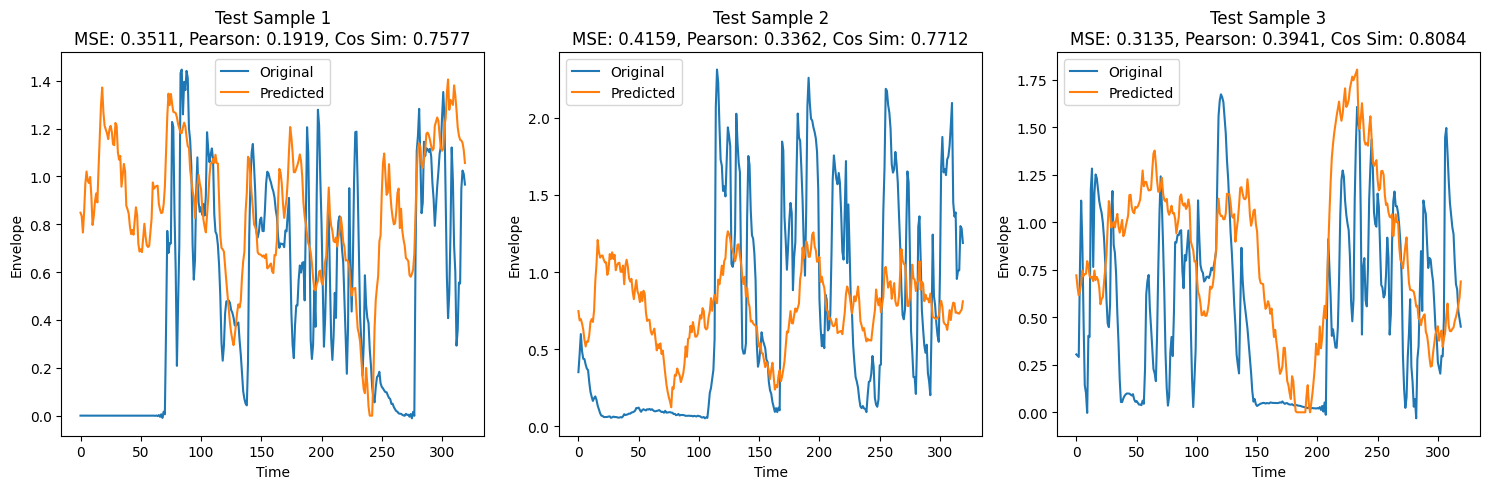

In [11]:
def plot_test_predictions(model, X_test, y_test, num_samples=3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    indices = np.random.choice(X_test.shape[0], num_samples, replace=False)
    X_samples, y_samples = X_test[indices], y_test[indices]
    
    plt.figure(figsize=(15, 5))
    with torch.no_grad():
        X_samples = X_samples.to(device)
        preds = model(X_samples).cpu().numpy()
        y_samples = y_samples.numpy()

    for i in range(num_samples):
        # Compute per-sample metrics
        pred = preds[i]
        target = y_samples[i]
        mse = mean_squared_error(target, pred)
        pearson = pearsonr(target, pred)[0]
        cos_sim = np.dot(target, pred) / (np.linalg.norm(target) * np.linalg.norm(pred) + 1e-8)
        
        # Plot
        plt.subplot(1, num_samples, i + 1)
        plt.plot(target, label='Original')
        plt.plot(pred, label='Predicted')
        plt.title(f'Test Sample {i+1}\nMSE: {mse:.4f}, Pearson: {pearson:.4f}, Cos Sim: {cos_sim:.4f}')
        plt.xlabel('Time')
        plt.ylabel('Envelope')
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    
plot_test_predictions(model, X_test, y_test)

In [13]:
import seaborn as sns

# Function to compute per-sample metrics for the test set
def compute_per_sample_metrics(model, X_test, y_test, batch_size):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_test, y_test),
        batch_size=batch_size
    )
    pearson_scores = []
    cos_sim_scores = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            preds = model(batch_X).cpu().numpy()
            targets = batch_y.cpu().numpy()
            for pred, target in zip(preds, targets):
                pearson = pearsonr(target, pred)[0]
                cos_sim = np.dot(target, pred) / (np.linalg.norm(target) * np.linalg.norm(pred) + 1e-8)
                pearson_scores.append(pearson)
                cos_sim_scores.append(cos_sim)

    return np.array(pearson_scores), np.array(cos_sim_scores)

# Function to plot violin plots for Pearson correlation and cosine similarity
def plot_violin_metrics(pearson_scores, cos_sim_scores):
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=[pearson_scores, cos_sim_scores], palette="muted")
    plt.xticks([0, 1], ['Pearson Correlation', 'Cosine Similarity'])
    plt.ylabel('Score')
    plt.title('Distribution of Pearson Correlation and Cosine Similarity on Test Set')
    plt.tight_layout()
    plt.show()


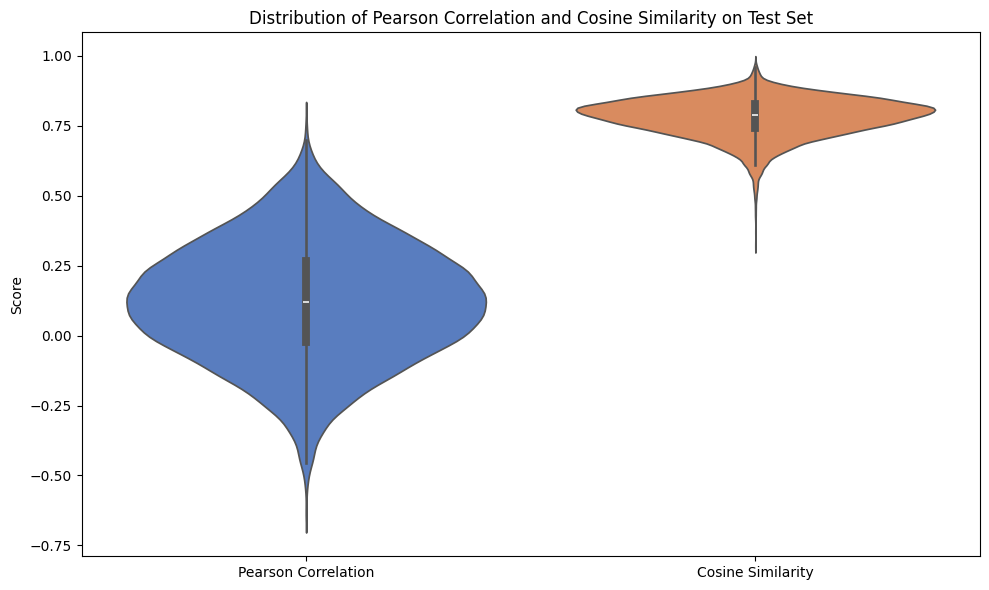

In [16]:
pearson_scores, cos_sim_scores = compute_per_sample_metrics(model, X_test, y_test, hyperparameters['batch_size'])
plot_violin_metrics(pearson_scores, cos_sim_scores)